In [4]:
import Config as conf
import Lockin
import FileInfo
import matplotlib.pyplot as plt
#%matplotlib qt
import numpy as np
import math
import os
import ROOT
import time
import pandas as pd

In [2]:
Bin_or_Float = conf.Bin_or_Float

print("aa")
if Bin_or_Float == "Float":
    print(conf.DataName)
    df = pd.read_table(conf.DataName, sep=" ", names = ["time", "signal"])
    Time = np.array(df.time, dtype="d")
    V_mean = np.array(df.signal, dtype="d")

else:
    #StartNo = FileInfo.GetMaxFileNumber() + 1
    #StopNo  = conf.NumOfDataAcquisition
    file_list = os.listdir(conf.DataPath)
    data_list = []
    print(conf.DataPath)

    for i in range(len(file_list)):
        if ".bin" == os.path.splitext(file_list[i])[1]:
            data_list.append(os.path.join(conf.DataPath, file_list[i]))

    print(len(data_list))

    for i in range(len(data_list)):
        BinaryFileName = data_list[i]
        V, Time = Lockin.Lockin(BinaryFileName)
        #V = np.array([V[i] + 0.05*np.exp(-100*Time[i]) for i in range(len(V))])
        #print("read %d th data" %i)
        if i == 0:
            #plt.plot(Time, V, ".")
            #plt.show()
            V_mean = np.array([0.0 for i in range(len(V))])
        V_mean += V

    V_mean = V_mean/len(data_list)


aa
/home/nishi_gaku/FIDNMR//Data/2023/0616/131Xe_234A_19kHz/run2/floatData.txt


In [5]:
df = pd.read_csv(conf.DataName, sep=",", names = ["time", "signal"])
Time = np.array(df.time, dtype="d")
V_mean = np.array(df.signal, dtype="d")

In [6]:
def FindFreqDeltaLockin(StartF, EndF, Naverage, Time, V_mean):
    FreqList = []
    deltaList = []
    LockinList = []
    
    deltaRange = np.linspace(0., 2*math.pi, 10)
    #deltaRange = np.linspace(0.9*math.pi, 1.1*math.pi, 50)
    for f0 in range(StartF, EndF, 10):
        for delta in deltaRange:
            LockinValue = 0
            for i in range(Naverage):
                LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+delta)
                if i == Naverage-1:
                    FreqList.append(f0)
                    deltaList.append(delta)
                    LockinList.append(LockinValue)
                    
    return FreqList, deltaList, LockinList

def FindFreqLockin(StartF, EndF, dFreq, Naverage, Time, V_mean):
    FreqList = []
    LockinList = []
    #for f0 in range(StartF, EndF, dFreq):
    for f0 in np.arange(StartF, EndF, dFreq):
        LockinValue = 0
        LockinValue0 = 0
        LockinValue90 = 0
        for i in range(Naverage):
            t0 = Time[0]
            #LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+math.pi)
            #LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i])
            LockinValue0 += V_mean[i]*math.cos(2*math.pi*f0*Time[i])
            #LockinValue90 += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+math.pi/2)
        t1 = Time[i]
        LockinValue = math.sqrt(LockinValue0**2 + LockinValue90**2)
        FreqList.append(f0)
        #LockinList.append(LockinValue/(t1-t0))
        LockinList.append(LockinValue0/(t1-t0))
                    
    return FreqList, LockinList

def FindDeltaLockin(f0, dDelta, Naverage, Time, V_mean):
    FreqList = []
    deltaList = []
    LockinList = []
    
    deltaRange = np.linspace(0., 2*math.pi, dDelta)
    for delta in deltaRange:
        LockinValue = 0
        for i in range(Naverage):
            t0 = Time[0]
            LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+delta)
            #LockinValue += V_mean[i]*math.cos(2*math.pi*f0*Time[i])
            if i == Naverage-1:
                t1 = Time[i]
                deltaList.append(delta)
                LockinList.append(LockinValue/(t1-t0))
                    
    return deltaList, LockinList

def FinalLockin(f0, Delta, Nstart, Nend, Naverage, Time, V_mean):
    aveTime = []
    LockinList = []
    start_time = time.time()
    for  j in range(int((Nend-Nstart)/Naverage)):
        LockinValue = 0
        LockinValue0 = 0
        LockinValue90 = 0
        for i in range(j*Naverage, (j+1)*Naverage):
            t0 = Time[j*Naverage]
            t1 = Time[(j+1)*Naverage-1]
            t_ave = (t0+t1)/2
            LockinValue0 += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+Delta)
            #LockinValue90 += V_mean[i]*math.cos(2*math.pi*f0*Time[i]+Delta+math.pi/2)
        #LockinValue = math.sqrt(LockinValue0**2 + LockinValue90**2)
        aveTime.append(t_ave)
        #LockinList.append(LockinValue/(t1-t0))
        LockinList.append(LockinValue0/(t1-t0))
    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time normal:", execution_time, "seconds")
    return aveTime, LockinList



In [4]:
FreqList, deltaList, LockinList = FindFreqDeltaLockin(18000, 20000, 1000, Time, V_mean)
df = pd.DataFrame({"freq": FreqList, "delta":deltaList, "Lockin": LockinList})
df_s = df.sort_values(by = "Lockin", ascending=False)
print(df_s[:10])
"""
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(FreqList, deltaList, LockinList)
plt.show()
"""

       freq     delta     Lockin
911   18910  0.698132  18.451882
1005  19000  3.490659  18.434614
826   18820  4.188790  18.421862
939   18930  6.283185  18.414988
930   18930  0.000000  18.414988
1024  19020  2.792527  18.395121
845   18840  3.490659  18.387673
892   18890  1.396263  18.378967
1090  19090  0.000000  18.370126
1099  19090  6.283185  18.370126


"\nfig = plt.figure()\nax = fig.add_subplot(projection='3d')\nax.scatter(FreqList, deltaList, LockinList)\nplt.show()\n"

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(FreqList, deltaList, LockinList)
plt.show()

In [9]:
#Naverage = len(Time)
FreqDeltaNaverage = len(Time)

FreqList, LockinList = FindFreqLockin(18300, 19000, 0.1, FreqDeltaNaverage, Time, V_mean)
#FreqList, LockinList = FindFreqLockin(18990, 19050, 0.1, FreqDeltaNaverage, Time, V_mean)
"""
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(FreqList, LockinList)
plt.show()
"""

'\nfig = plt.figure()\nax = fig.add_subplot()\nax.scatter(FreqList, LockinList)\nplt.show()\n'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


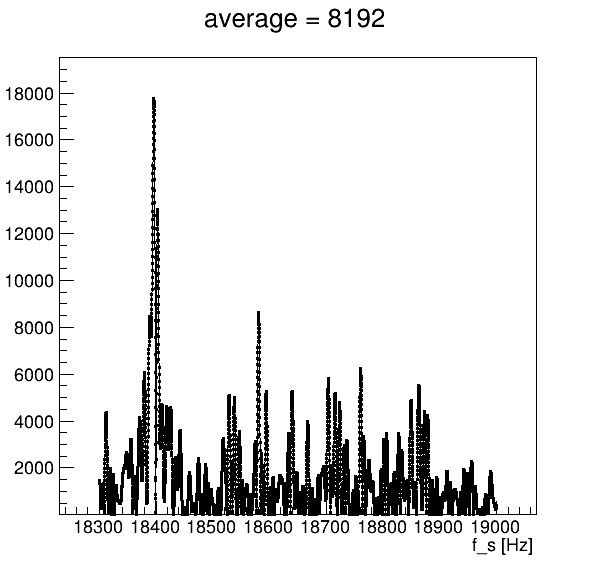

In [10]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = ROOT.TGraph(len(FreqList), np.array(FreqList, dtype="d"), np.abs(np.array(LockinList)))
#gr = ROOT.TGraph(len(FreqList), np.array(FreqList, dtype="d"), np.array(LockinList))
gr.Draw("APL")
gr.SetMarkerStyle(7)
gr.SetMarkerSize(10)
gr.SetTitle("average = %d"%FreqDeltaNaverage)
gr.GetXaxis().SetTitle("f_s [Hz]")
#c1 = ROOT.gROOT.FindObject("c1")
c1.Draw("same")
#c1.Update()

In [11]:
df = pd.DataFrame({"freq": FreqList, "Lockin": np.abs(LockinList)})
df_s = df.sort_values(by = "Lockin", ascending=False)
df_r = df_s.reset_index(drop=True)
F0 = df_r.freq[0]
print(df_r[:10])

      freq        Lockin
0  18396.0  17752.903270
1  18396.1  17750.851361
2  18395.9  17725.216486
3  18396.2  17718.196059
4  18395.8  17668.755884
5  18396.3  17654.177798
6  18395.7  17584.581128
7  18396.4  17558.146662
8  18395.6  17473.840897
9  18396.5  17429.566423


In [12]:
#Naverage = 100000
#F0 = 18900.68255588443
#DeltaList, LockinList = FindDeltaLockin(18955, 1000, Naverage, Time, V_mean) #Naverage=166666
DeltaList, LockinList = FindDeltaLockin(F0, 1000, FreqDeltaNaverage, Time, V_mean) #Naverage=1000

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


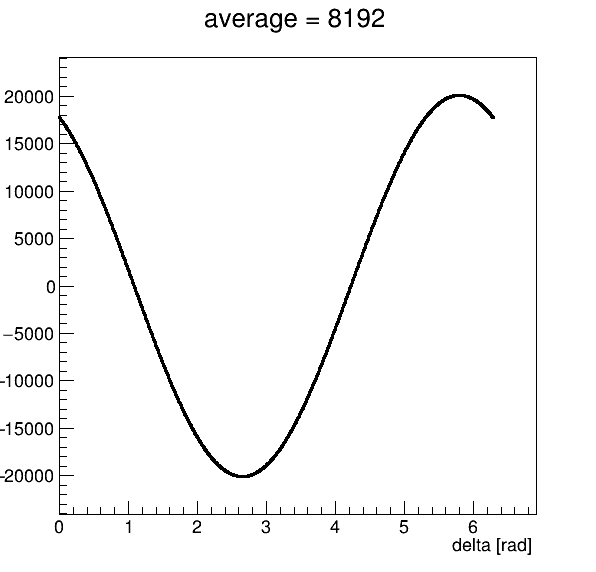

In [13]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = ROOT.TGraph(len(DeltaList), np.array(DeltaList), np.array(LockinList))
gr.Draw("APL")
gr.SetMarkerStyle(7)
gr.SetMarkerSize(10)
gr.SetTitle("average = %d"%FreqDeltaNaverage)
gr.GetXaxis().SetTitle("delta [rad]")
#c1 = ROOT.gROOT.FindObject("c1")
c1.Draw("same")
#c1.Update()

In [14]:
df = pd.DataFrame({"delta": DeltaList, "Lockin": LockinList})
df_s = df.sort_values(by = "Lockin", ascending=False)
df_r = df_s.reset_index(drop=True)
Delta0 = df_r.delta[0]
print(df_r.delta[0])

5.792606274186585


In [18]:
df = pd.read_table("./Data/2023/0616/131Xe_100A_19kHz/run2/floatData.txt", sep=" ", names = ["time", "signal"])
Time1 = np.array(df.time, dtype="d")
V_mean1 = np.array(df.signal, dtype="d")

In [16]:
FinalNaverage = 1000

#aveTime, LockinList = FinalLockin(18955, 0.157237, 0, 150000, Naverage, Time, V_mean) #0616/131Xe_234_19kHz/run2
#aveTime, LockinList = FinalLockin(18955, 0.213842, 0, 150000, Naverage, Time, V_mean) #0616/131Xe_234_19kHz/run2
#aveTime, LockinList = FinalLockin(18971, 0.0, 0, 150000, Naverage, Time, V_mean) #0616/131Xe_234_19kHz/run2
aveTime, LockinList = FinalLockin(F0, Delta0, 0, len(Time)-1, FinalNaverage, Time, V_mean) #0614/129Xe_069_19kHz/run2
#aveTime, LockinList = FinalLockin(18920, 0, 0, 150000, Naverage, Time, V_mean) #0614/129Xe_069_19kHz/run2
#aveTime, LockinList = FinalLockin(18920, 0.5*math.pi, 0, 50000, Naverage, Time, V_mean) #0614/129Xe_069_19kHz/run2

#aveTime1, LockinList1 = FinalLockin(F0, Delta0, 0, 150000, FinalNaverage, Time1, V_mean1)
"""
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(aveTime, LockinList, label = "average = %d"%Naverage)
#ax.scatter(aveTime, LockinList)
ax.grid()
ax.legend()
plt.show()
"""

Execution time normal: 0.02627396583557129 seconds


'\nfig = plt.figure()\nax = fig.add_subplot()\nax.plot(aveTime, LockinList, label = "average = %d"%Naverage)\n#ax.scatter(aveTime, LockinList)\nax.grid()\nax.legend()\nplt.show()\n'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


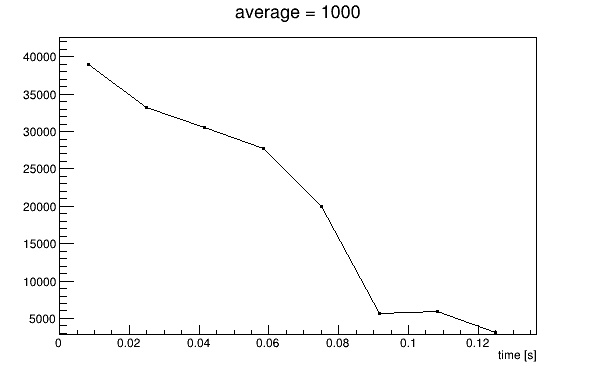

In [22]:
c1 = ROOT.TCanvas("c1", "c1", 600, 400)
gr = ROOT.TGraph(len(aveTime), np.array(aveTime), np.array(LockinList))
#gr = ROOT.TGraph(len(aveTime1), np.array(aveTime1), np.array(LockinList1))
gr_fit = ROOT.TF1("f", "[0]*expo(-[1]*x)", aveTime[0], aveTime[-1])
gr_fit.SetParameters(40000., 12.5)
gr.Fit(gr_fit, "QR")
#par = [gr_fit.GetParameter(k) for k in range(gr_fit.GetNpar())]
gr.Draw("APL")
gr.SetMarkerStyle(7)
gr.SetMarkerSize(10)
gr.SetTitle("average = %d"%FinalNaverage)
gr.GetXaxis().SetTitle("time [s]")
gr_fit.Draw("same")
#c1 = ROOT.gROOT.FindObject("c1")
c1.Draw("same")
#c1.Update()

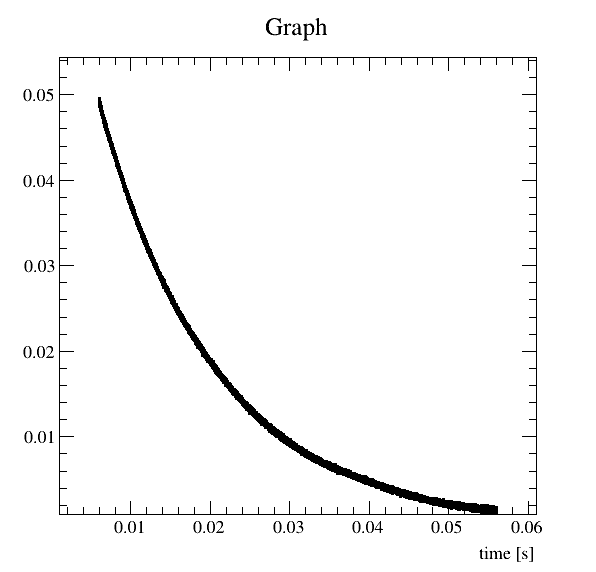

In [4]:
c1 = ROOT.TCanvas("c1", "c1", 600, 600)
gr = ROOT.TGraph(len(Time), np.array(Time), np.array(V_mean))
gr.Draw("APL")
gr.SetMarkerStyle(7)
gr.SetMarkerSize(10)
#gr.SetTitle("average = %d"%Naverage)
gr.GetXaxis().SetTitle("time [s]")
#c1 = ROOT.gROOT.FindObject("c1")
c1.Draw("same")
#c1.Update()

In [19]:
a = df_s.delta[999]
a

6.283185307179586